In [1]:
import nbimporter
from Data_preprocessing import * 
from Volatility import *

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
%run "/Users/nickarhi/Desktop/Studying/Project HSE 4th course/Codes/Data_preprocessing.ipynb"

         Date     Price  Volume  Price change  Volume change
0  2024-04-04  2,449.00     0.0          0.82            NaN
1  2024-04-03  2,429.00     0.0          2.06            NaN


/var/folders/gk/lwvxlf616ggf8j4h0y1hjl6c0000gn/T/ipykernel_74968/1671314584.py:2: FutureWarning: Passing 'suffixes' as a <class 'str'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  return_df = return_df.merge(brent[['Date', 'Price change']], on='Date', how='left', suffixes=('_brent'))
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
         Date     Price  Volume  Price change  Volume change
0  2024-04-04  2,449.00     0.0          0.82            NaN
1  2024-04-03  2,429.00     0.0          2.06            NaN
Date                      0
Price change              0
Price change_cofee        0
Price change_copper       0
Price change_corn         0
Price change_cotton       0
Price change_gasoline     0
Price change_gold         0
Price change_nickel       0
Price change_palladium    0
Price change_silver       0
Price change_soybean      0
Price change_wheat        0
Price change_wti          0
Price change_zinc         0
Price change_cocoa        0
dtype: int64
Date             0
brent_log        0
cocoa_log        0
cofee_log        0
copper_log       0
corn_log         0
cotton_log       0
gasoline_log     0
gold_log         0
nickel_l

/var/folders/gk/lwvxlf616ggf8j4h0y1hjl6c0000gn/T/ipykernel_74968/1671314584.py:2: FutureWarning: Passing 'suffixes' as a <class 'str'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  return_df = return_df.merge(brent[['Date', 'Price change']], on='Date', how='left', suffixes=('_brent'))
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


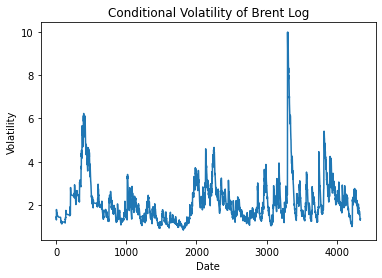

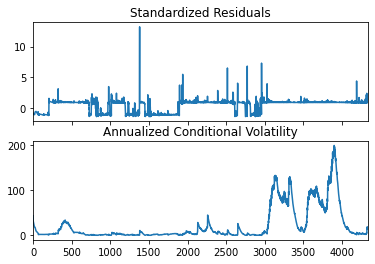

Ljung-Box test on residuals:
            lb_stat  lb_pvalue
100  262975.691951        0.0
ARCH test on residuals:
 (3831.9047686774093, 0.0, 66647.91063296505, 0.0)
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                     gold_log   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5275.54
Distribution:      Standardized Student's t   AIC:                           10563.1
Method:                  Maximum Likelihood   BIC:                           10600.6
                                              No. Observations:                 3864
Date:                      Sat, Apr 20 2024   Df Residuals:                     3863
Time:                              20:04:55   Df Model:                            1
                                 Mean Model                           

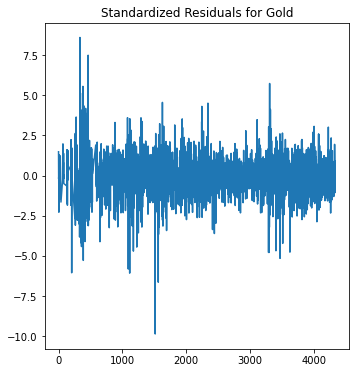

In [ ]:
%run "/Users/nickarhi/Desktop/Studying/Project HSE 4th course/Codes/Volatility.ipynb"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import size, log, pi, sum, array, zeros, diag, mat, asarray, sqrt, \
    copy
from numpy.linalg import inv
from scipy.optimize import fmin_slsqp

In [ ]:
def gjr_garch_likelihood(parameters, data, sigma2, out=None):
    mu = parameters[0]
    omega = parameters[1]
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]
    
    T = size(data,0)
    eps = data - mu
    for t in range(1,T):
        sigma2[t] = (omega + alpha * eps[t-1]**2 
                     + gamma * eps[t-1]**2 * (eps[t-1]<0) + beta * sigma2[t-1])
        sigma2[t] = max(sigma2[t], 1e-10)
    
    logliks = 0.5*(log(2*pi) + log(sigma2) + eps**2/sigma2)
    loglik = sum(logliks)
    
    if out is None:
        return loglik
    else:
        return loglik, logliks, copy(sigma2)
    

def gjr_constraint(parameters, data, sigma2, out=None):
    ''' Constraint that alpha+gamma/2+beta<=1'''
    
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]

    return array([1-alpha-gamma/2-beta])

def hessian_2sided(fun, theta, args):
    f = fun(theta, *args)
    h = 1e-5*np.abs(theta)
    h[h == 0] = 1e-7
    thetah = theta + h
    h = thetah - theta
    K = size(theta,0)
    h = np.diag(h)
    
    fp = zeros(K)
    fm = zeros(K)
    for i in range(K):
        fp[i] = fun(theta+h[i], *args)
        fm[i] = fun(theta-h[i], *args)
        
    fpp = zeros((K,K))
    fmm = zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j],  *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(theta - h[i] - h[j],  *args)
            fmm[j,i] = fmm[i,j]
            
    hh = (diag(h))
    hh = hh.reshape((K,1))
    hh = hh @ hh.T
    
    H = zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f 
                       + f - fm[i] - fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    
    return H

In [ ]:
test_col = return_log_scaled['gold_log']
test_col.reset_index(drop=True, inplace=True)

startingVals = array([test_col.mean(),
                      test_col.var() * .01,
                      .03, .09, .90])

finfo = np.finfo(np.float64)
bounds = [(-10*test_col.mean(), 10*test_col.mean()),
          (finfo.eps, 2*test_col.var() ),
          (0.0,1.0), (0.0,1.0), (0.0,1.0)]
       
T = test_col.shape[0]
sigma2 = np.ones(T) * test_col.var()
# Pass a NumPy array, not a pandas Series
args = (np.asarray(test_col), sigma2)
estimates = fmin_slsqp(gjr_garch_likelihood, startingVals,
                       f_ieqcons=gjr_constraint, bounds = bounds,
                       args = args)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5490.4570930343525
            Iterations: 15
            Function evaluations: 106
            Gradient evaluations: 15


In [ ]:
loglik, logliks, sigma2final = gjr_garch_likelihood(estimates, test_col,
                                                    sigma2, out=True)

In [ ]:
step = 1e-5 * estimates
scores = zeros((T,5))
for i in range(5):
    step[step == 0] = 1e-7
    h = step[i]
    delta = np.zeros(5)
    delta[i] = h
    
    loglik, logliksplus, sigma2 = gjr_garch_likelihood(estimates + delta, \
                               np.asarray(test_col), sigma2, out=True)
    loglik, logliksminus, sigma2 = gjr_garch_likelihood(estimates - delta, \
                              np.asarray(test_col), sigma2, out=True)                   
               
    scores[:,i] = (logliksplus - logliksminus)/(2*h)

I = (scores.T @ scores)/T

J = hessian_2sided(gjr_garch_likelihood, estimates, args)
J = J/T
Jinv = mat(inv(J))
vcv = Jinv*mat(I)*Jinv/T
vcv = asarray(vcv)

1.6974542686253614e-07
[1.96583243 1.02876296 1.01588731 ... 1.07379975 1.00168613 0.81164029]
[1.96583286 1.02876296 1.01588728 ... 1.07380008 1.00168591 0.81164023]
1.4715005246599938e-07
[1.96583265 1.02876302 1.01588741 ... 1.0738006  1.00168694 0.81164184]
[1.96583265 1.0287629  1.01588718 ... 1.07379923 1.0016851  0.81163868]
4.4712017092940624e-07
[1.96583265 1.02876337 1.01588769 ... 1.07380122 1.00168775 0.81164315]
[1.96583265 1.02876255 1.0158869  ... 1.07379861 1.00168429 0.81163737]
0.0
[1.96583265 1.02876296 1.01588729 ... 1.07379992 1.00168602 0.81164026]
[1.96583265 1.02876296 1.01588729 ... 1.07379992 1.00168602 0.81164026]


/var/folders/gk/lwvxlf616ggf8j4h0y1hjl6c0000gn/T/ipykernel_74968/1628861787.py:14: RuntimeWarning: invalid value encountered in true_divide
  scores[:,i] = (logliksplus - logliksminus)/(2*h)


9.42721136367513e-06
[1.96583265 1.02876746 1.01589645 ... 1.07383006 1.00172694 0.81171064]
[1.96583265 1.02875846 1.01587814 ... 1.07376978 1.00164511 0.8115699 ]


/var/folders/gk/lwvxlf616ggf8j4h0y1hjl6c0000gn/T/ipykernel_74968/786401781.py:62: RuntimeWarning: invalid value encountered in double_scalars
  H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f


In [ ]:
output = np.vstack((estimates,sqrt(diag(vcv)),estimates/sqrt(diag(vcv)))).T    
print('Parameter   Estimate       Std. Err.      T-stat')
param = ['mu','omega','alpha','gamma','beta']
for i in range(len(param)):
    print('{0:<11} {1:>0.6f}        {2:0.6f}    {3: 0.5f}'.format(param[i],
           output[i,0], output[i,1], output[i,2]))

Parameter   Estimate       Std. Err.      T-stat
mu          0.016975        nan     nan
omega       0.014715        nan     nan
alpha       0.044712        nan     nan
gamma       0.000000        nan     nan
beta        0.942721        nan     nan


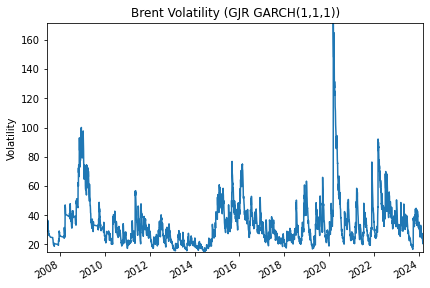

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Produce a plot
dates = return_log_scaled['Date']
fig = plt.figure()
ax = fig.add_subplot(111)
volatility = pd.DataFrame(np.sqrt(252 * sigma2), index=dates)
ax.plot(volatility.index,volatility)
ax.autoscale(tight='x')
fig.autofmt_xdate()
fig.tight_layout(pad=1.5)
ax.set_ylabel('Volatility')
ax.set_title('Brent Volatility (GJR GARCH(1,1,1))')
plt.show()